In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
import cv2
import os
from torchvision.transforms import ToTensor
from PIL import Image
import shutil
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In the data-preprocessing part, I have used modules like os, shutil etc. So, initally, all the images were in the same folder and it
contained both ground truth and the annotated images,which are given below. So, initially, the annotated images should be converted to 
binary mask image where there is white patch inside the contour(ellipse) and black outside it. after that, the data should be splitted into
train and validation sets and care should be taken to have the same images in train and validation from both ground truth and masked images respectively. Also, the data should be loaded in data loader, and the segmentation dataset class performs this task.

Using matplotlib's mpimg.imread():

This function reads an image and returns it in the format (Height, Width) for grayscale images, and (Height, Width, Channels) for color images.
In your case, when you use mpimg.imread() and get the shape (540, 800), it indicates that the image is being read as a grayscale image with 540 rows and 800 columns.

Using cv2.imread():

OpenCV's cv2.imread() function, by default, reads images in BGR format and always returns a 3-channel image, even if the original image is grayscale.
The shape (3, 540, 800) you're observing is unusual as OpenCV typically returns images in the format (Height, Width, Channels). A shape of (3, 540, 800) would imply three images of size 540x800, which doesn't seem correct for a standard image read operation.
There might be a misunderstanding or error with the way you're printing the shape of the image read by OpenCV. Normally, you should expect a shape like (540, 800, 3) for a color image. Here's the correct way to load and print the shape of an image using OpenCV:


(540, 800)


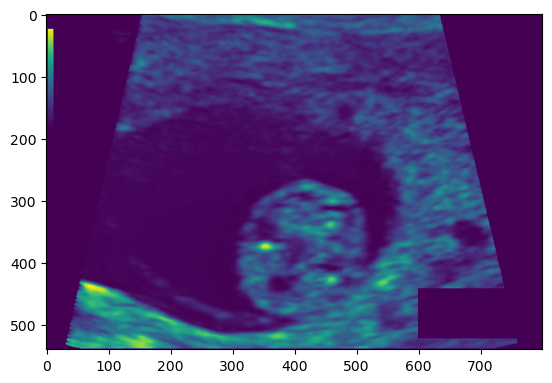

In [2]:
img = mpimg.imread("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set/1_HC.png")
print(img.shape)
plt.imshow(img)
plt.show()

(540, 800)


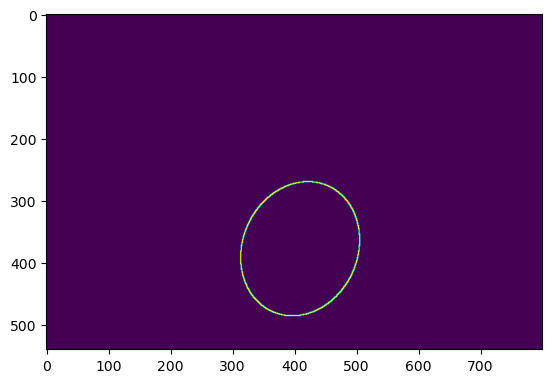

In [4]:
img = mpimg.imread("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set/1_HC_Annotation.png")
plt.imshow(img)
print(img.shape)
plt.show()

(540, 800, 3)


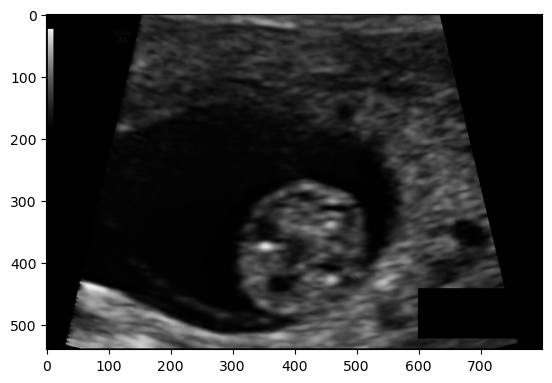

In [5]:
'''here, cv2.imread() automatically reads the function in RGB format'''
image = cv2.imread("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set/1_HC.png")
print(image.shape)
plt.imshow(image)
plt.show()

(540, 800)


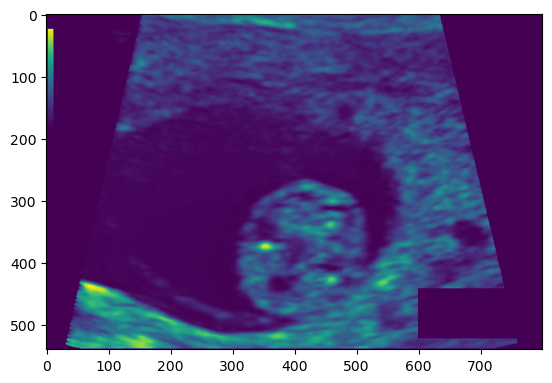

In [6]:
image = cv2.imread("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set/1_HC.png")
# Convert the image to grayscale from RGB
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(gray_image.shape)
plt.imshow(gray_image)
plt.show()

In [7]:
'''another way to read  the image directly in GrayScale format'''
image = cv2.imread("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set/1_HC.png", cv2.IMREAD_GRAYSCALE)
print(image.shape)  # Expected to print (Height, Width) for a grayscale image


(540, 800)


In [10]:
# Directory containing the images
train_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set'
root_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net'

In [8]:
train_pixel_file = pd.read_csv('/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set_pixel_size_and_HC.csv')
train_pixel_file=pd.DataFrame(train_pixel_file)
train_pixel_file

,filename,pixel size,head circumference (mm)
0,1_HC.png,0.069136,44.30
1,2_HC.png,0.089659,56.81
2,3_HC.png,0.062033,68.75
3,4_HC.png,0.091291,69.00
4,5_HC.png,0.061240,59.81
...,...,...,...
994,995_HC.png,0.296851,329.26
995,996_HC.png,0.212267,330.90
996,997_HC.png,0.202743,331.70
997,998_HC.png,0.281090,316.48


In [21]:
'''.iloc function usage'''
print(train_pixel_file.iloc[0,0]) #0 th row and 0th column
print(train_pixel_file.iloc[1,0]) #1st row and zeroth column
print(train_pixel_file.iloc[0,1])
print(train_pixel_file.iloc[1,1])

1_HC.png
2_HC.png
0.0691358041432
0.0896585200514


In [58]:
file_path = "/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set/1_HC.png"
image = Image.open(file_path)
print(image.mode)
# Define a transformation to convert the image to a tensor
transform = transforms.Compose([transforms.ToTensor()])

# Apply the transformation to the image
image_tensor = transform(image)

# Print the size of the tensor
print(image_tensor.size())

# Print min and max pixel values in the tensor
print("Min pixel value:", torch.min(image_tensor).item())
print("Max pixel value:", torch.max(image_tensor).item())



'''from the pixel values, we can find that it is already normalised between 0 and 1'''

L
torch.Size([1, 540, 800])
Min pixel value: 0.0
Max pixel value: 0.9529411792755127


'from the pixel values, we can find that it is already normalised between 0 and 1'

In [65]:
file_path = "/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set/1_HC_Annotation.png"
image = Image.open(file_path)
print(image.mode)

# Define a transformation to convert the image to a tensor
transform = transforms.Compose([transforms.ToTensor()])

# Apply the transformation to the image
image_tensor = transform(image)

# Print the size of the tensor
print(image_tensor.size())
print(image_tensor)

# Print min and max pixel values in the tensor
print("Min pixel value:", torch.min(image_tensor).item())
print("Max pixel value:", torch.max(image_tensor).item())



'''from the pixel values, we can find that it is already normalised between 0 and 1'''

L
torch.Size([1, 540, 800])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Min pixel value: 0.0
Max pixel value: 1.0


'from the pixel values, we can find that it is already normalised between 0 and 1'

In [14]:
a=cv2.imread("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set/1_HC_Annotation.png")
'''when the data is read using cv2.imread(), we are getting rgb channels(3)''' 

# Apply the transformation to the image
# from torchvision.transforms import ToTensor  this is the module to be imported 
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(a)
# Print the size of the tensor
print(image_tensor.size())
print(image_tensor)
# Print min and max pixel values in the tensor
print("Min pixel value:", torch.min(image_tensor))#.item())
print("Max pixel value:", torch.max(image_tensor).item())

'''from the pixel values, we can find that it is already binary'''

torch.Size([3, 540, 800])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Min pixel value: tensor(0.)
Max pixel value: 1.0


'from the pixel values, we can find that it is already binary'

In [30]:
'''function to generate the mask'''
def masking(image):
    '''This function converts the image to RGB format as we are using cv2 to load the images'''
    
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    '''This line converts the input image from the BGR color space (used by OpenCV) to a 
    grayscale image. Grayscale images are easier to process when you only need to analyze shapes or contours, as color information 
    is not needed.'''

    
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(imgray)
    # #Print the size of the tensor
    # print(image_tensor.size())

    # # Print min and max pixel values in the tensor
    # print("Min pixel value:", torch.min(image_tensor).item())
    # print("Max pixel value:", torch.max(image_tensor).item())

    '''this can be used to make the images binary, but here the given images are already in binary form, so there is no need 
    to threshold the pixels'''
    ret, thresh = cv2.threshold(imgray, 127, 255, 0) 
    # 'image' is normalized between 0 and 1
    #ret, thresh = cv2.threshold(imgray, 0.5, 1, 0)  # Adjust threshold values
    #thresh = (thresh * 255).astype(np.uint8)  Optional: Scale back to 0-255 if needed

    contours, hierarchy = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(np.zeros_like(image), ellipse, (255, 255, 255), -1)


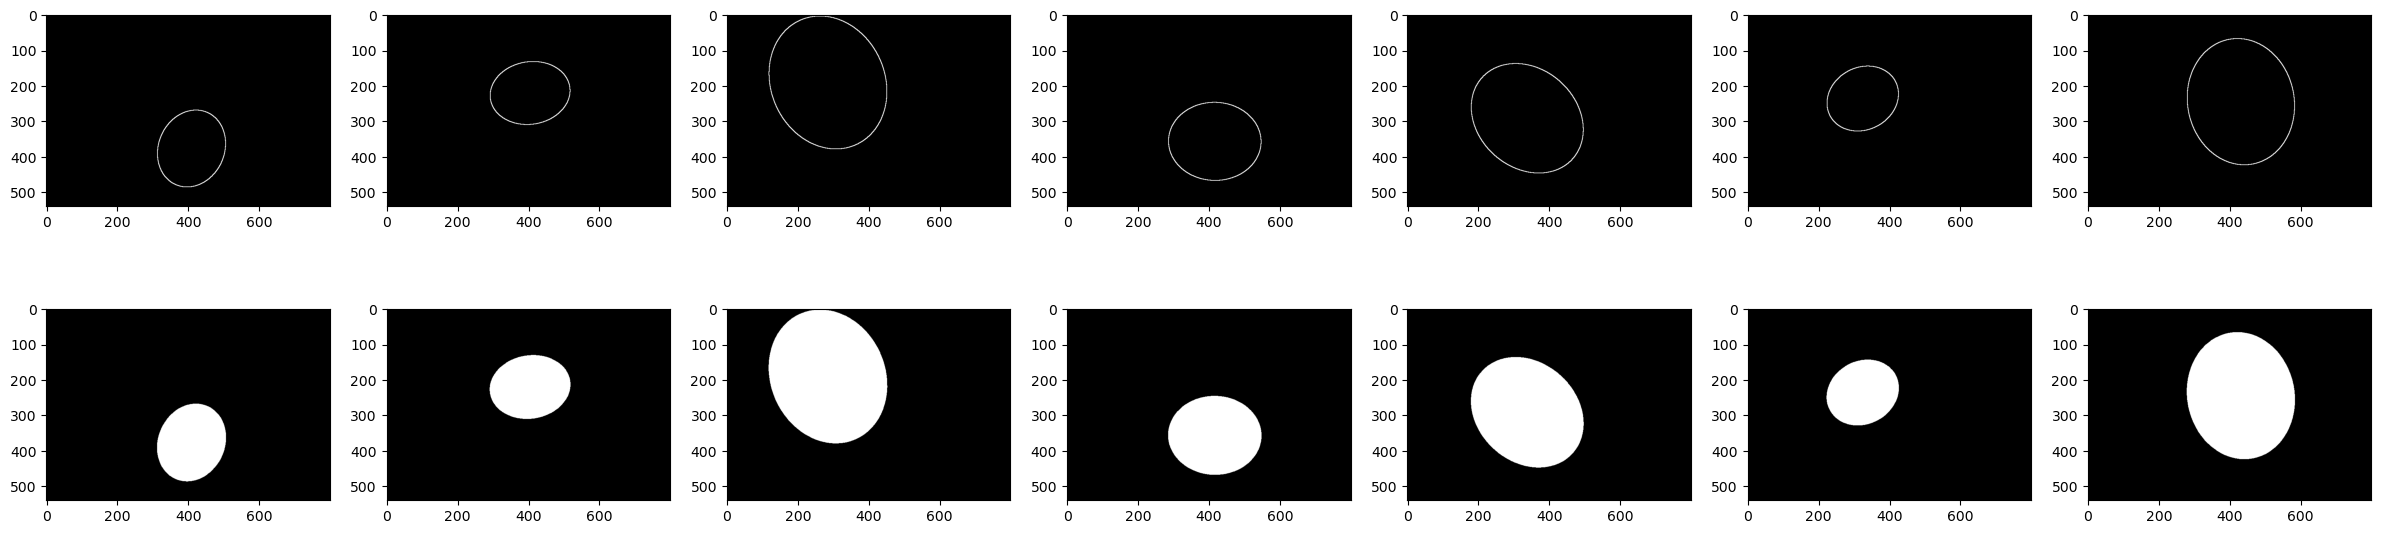

In [31]:
'''to check if our masking function is working correctly'''
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = os.path.join("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set", 
                           train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  #print(file_path)
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

In [32]:
'''here,the masks are generated'''

image_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set'
save_directory = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/masked'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    
    for filename in os.listdir(image_dir):
        if filename.endswith("Annotation.png"): 
            # Load image
            img_path = os.path.join(image_dir, filename)
            img = cv2.imread(img_path)
            masked_image = masking(img)

            # Save the modified image
            save_path = os.path.join(save_directory, filename)
            cv2.imwrite(save_path, masked_image) #here, cv2.imwrite() can be used to save an image and will be saved in RGB format.

            # Optionally, display the image (remove this in production)
            #plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
            #plt.show()

RGB
torch.Size([3, 540, 800])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(1.)
tensor(0.)
tensor(99336.)


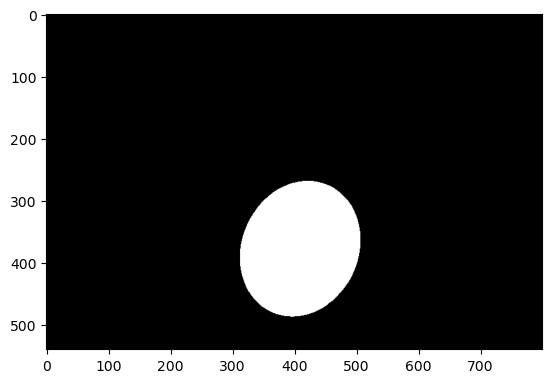

In [47]:
'''playing around with the binary-masked sample'''
# Define the path to the image
e = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/masked/1_HC_Annotation.png'

# Open the image
im = Image.open(e)
plt.imshow(im)
# Print the image mode
print(im.mode)

# Define the transformation
transform = ToTensor()

# Apply the transformation to the image to convert it to a tensor
a = transform(im)

# a now contains the image data as a PyTorch tensor
print(a.size())
print(a)
print(torch.max(a[0]))
print(torch.min(a))
print(a.sum())

In [48]:
def copy_image_to_folder(src_image_path, dest_folder_path):
    # Check if the destination folder exists, create if not
    if not os.path.exists(dest_folder_path):
        os.makedirs(dest_folder_path)
    
    # Define the destination image path
    dest_image_path = os.path.join(dest_folder_path, os.path.basename(src_image_path))
    
    # Read the source image in binary mode and write to the destination
    with open(src_image_path, 'rb') as src_file:
        image_data = src_file.read()
        with open(dest_image_path, 'wb') as dest_file:
            dest_file.write(image_data)
    
    return dest_image_path  # Optional, returns the new image path

In [49]:
'''ground_truth (un-annotated images)'''
image_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set'
ground_truth_path = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/ground_truth'

# Ensure the ground truth path exists
if not os.path.exists(ground_truth_path):
    os.makedirs(ground_truth_path)
 
# Copy images
    for filename in os.listdir(image_dir):
        if filename.endswith("HC.png"): 
            src_image_path = os.path.join(image_dir, filename)  # Corrected to 'filename'
            dest_folder_path = ground_truth_path
        
            # Copy the image
            new_image_path = copy_image_to_folder(src_image_path, dest_folder_path)  # Added closing parenthesis
            #print(f"Image copied to: {new_image_path}")

L
torch.Size([1, 540, 800])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(0.9529)
tensor(0.)
tensor(50509.2031)


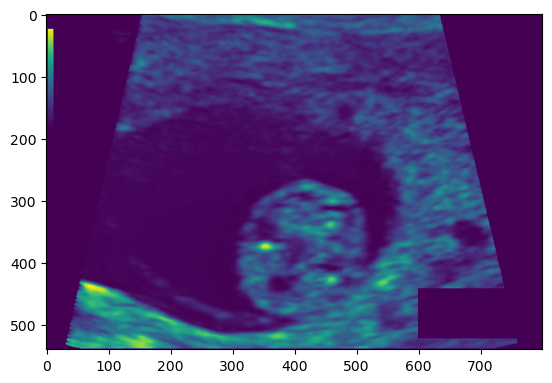

In [53]:
e = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/ground_truth/1_HC.png'

# Open the image
im = Image.open(e)
plt.imshow(im)
# Print the image mode
print(im.mode)

# Define the transformation
transform = ToTensor()

# Apply the transformation to the image to convert it to a tensor
a = transform(im)

# a now contains the image data as a PyTorch tensor
print(a.size())
print(a)
print(torch.max(a[0]))
print(torch.min(a))
print(a.sum())

In [66]:
'''annotated images with green ellipses are copied to a new folder here'''
image_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set'
annotated = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/annotated'

# Ensure the ground truth path exists
if not os.path.exists(annotated):
    os.makedirs(annotated)
 
# Copy images
    for filename in os.listdir(image_dir):
        if filename.endswith("Annotation.png"): 
            src_image_path = os.path.join(image_dir, filename)  # Corrected to 'filename'
            dest_folder_path = annotated
        
            # Copy the image
            new_image_path = copy_image_to_folder(src_image_path, dest_folder_path)  # Added closing parenthesis
            #print(f"Image copied to: {new_image_path}")

In [56]:
def copy_files(file_list, source_dir, dest_dir, mask=False):
    for filename in file_list:
        # If we're copying masks, modify the filename to match the mask naming convention
        if mask:
            filename = filename.replace('.png', '_Annotation.png')
        shutil.copy(os.path.join(source_dir, filename), os.path.join(dest_dir, filename))


In [57]:
# Paths to the image and mask directories
image_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/ground_truth'
mask_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/masked'

# Paths to the destination train and test directories for images and masks
train_image_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/train_image'
train_mask_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/train_mask'
val_image_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/val_image'
val_mask_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/val_mask'

# Create destination directories if they don't exist
for path in [train_image_dir, train_mask_dir, val_image_dir, val_mask_dir]:
    os.makedirs(path, exist_ok=True)

# Get list of image filenames (assuming image and mask filenames are identical)
filenames = os.listdir(image_dir)

# Split filenames into train and test sets
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2, random_state=5)

# Copy training and testing images and masks
copy_files(train_filenames, image_dir, train_image_dir)
copy_files(train_filenames, mask_dir, train_mask_dir, mask=True)
copy_files(val_filenames, image_dir, val_image_dir)
copy_files(val_filenames, mask_dir, val_mask_dir,mask=True)

print("Splitting complete. Training and testing images and masks are copied.")


Splitting complete. Training and testing images and masks are copied.


In [67]:
'''to know the shape of images, by loading the images into a tensor and to find how .transform() works!'''
for index in range(7):
    file_path = os.path.join("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set", 
                           train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
    image = Image.open(file_path)

# Define a transformation to convert the image to a tensor
    transform = transforms.Compose([transforms.ToTensor()])

# Apply the transformation to the image
    image_tensor = transform(image)

    # Now, image_tensor contains the image as a PyTorch tensor
    print(image_tensor.size())

torch.Size([1, 540, 800])
torch.Size([1, 540, 800])
torch.Size([1, 540, 800])
torch.Size([1, 540, 800])
torch.Size([1, 540, 800])
torch.Size([1, 540, 800])
torch.Size([1, 540, 800])


L
torch.Size([1, 540, 800])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(0.9529)
tensor(0.)
tensor(50509.2031)


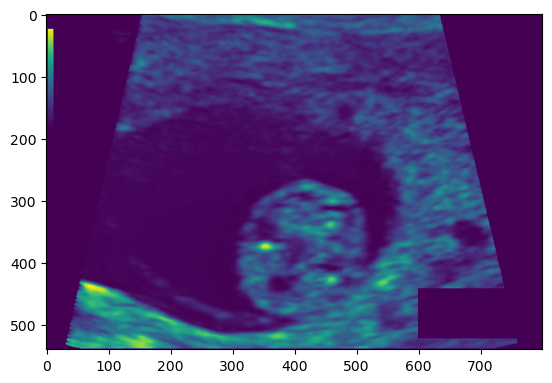

In [62]:
e = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/train_image/1_HC.png'

# Open the image
im = Image.open(e)
plt.imshow(im)
# Print the image mode
print(im.mode)

# Define the transformation
transform = ToTensor()

# Apply the transformation to the image to convert it to a tensor
a = transform(im)

# a now contains the image data as a PyTorch tensor
print(a.size())
print(a)
print(torch.max(a[0]))
print(torch.min(a))
print(a.sum())

RGB
torch.Size([3, 540, 800])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(1.)
tensor(0.)
tensor(99336.)


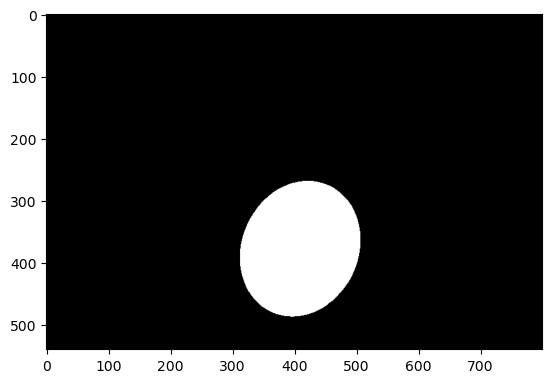

In [68]:
e = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/train_mask/1_HC_Annotation.png'

# Open the image
im = Image.open(e)
plt.imshow(im)
# Print the image mode
print(im.mode)

# Define the transformation
transform = ToTensor()

# Apply the transformation to the image to convert it to a tensor
a = transform(im)

# a now contains the image data as a PyTorch tensor
print(a.size())
print(a)
print(torch.max(a[0]))
print(torch.min(a))
print(a.sum())
#Here, it is in RGB format because of loading it using cv2.imread()

In [43]:
'''to know the shape of images, by loading the images into a tensor and to find how .transform() works!'''
for index in range(7):
    file_path = os.path.join("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/training_set", 
                           train_pixel_file.iloc[index, 0])
    image = Image.open(file_path)

# Define a transformation to convert the image to a tensor
    transform = transforms.Compose([transforms.ToTensor()])

# Apply the transformation to the image
    image_tensor = transform(image)

    # Now, image_tensor contains the image as a PyTorch tensor
    print(image_tensor.size())

torch.Size([1, 540, 800])
torch.Size([1, 540, 800])
torch.Size([1, 540, 800])
torch.Size([1, 540, 800])
torch.Size([1, 540, 800])
torch.Size([1, 540, 800])
torch.Size([1, 540, 800])


In [69]:
'''this is how os.listdir() function works. It takes all the fienames and add it into a list'''
a = os.listdir('/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/train_image')
print(len(a))
b = os.listdir('/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/val_image')
print(len(b))
c = os.listdir('/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/train_mask')
print(len(c))
d = os.listdir('/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/val_mask')
print(len(d))

799
200
799
200


In [70]:
e = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/train_image/1_HC.png'
im = Image.open(e)
print(im.mode)

L


In [71]:
e = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/train_mask/1_HC_Annotation.png'
im = Image.open(e)
print(im.mode)

RGB


In [61]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.png', '_Annotation.png'))  # Adjust mask file extension if needed
        
        image = Image.open(image_path)#.convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
        
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image,mask


In [62]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor(),
])

# Create dataset instances
train_image_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/train_image'
train_mask_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/train_mask'
train_dataset= SegmentationDataset(train_image_dir, train_mask_dir, transform=transform)


In [63]:
train_dataset[0][1].shape

torch.Size([1, 572, 572])

In [64]:
train_dataset[0][0].shape

torch.Size([1, 572, 572])

In [65]:
print(len(train_dataset)) #__len__ function
print(train_dataset[0][0].shape)   #__getitem__ function
print(train_dataset[1][0].shape)   #__getitem__ function

799
torch.Size([1, 572, 572])
torch.Size([1, 572, 572])


In [66]:
# Create dataset instances for validation
val_image_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/val_image'
val_mask_dir = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/val_mask'
val_dataset = SegmentationDataset(val_image_dir, val_mask_dir, transform=transform)


In [67]:
print(len(val_dataset)) #__len__ function
print(val_dataset[0][0].shape)   #__getitem__ function
print(val_dataset[1][0].shape)   #__getitem__ function

200
torch.Size([1, 572, 572])
torch.Size([1, 572, 572])


In [31]:
tloader = DataLoader(train_dataset,batch_size=32,shuffle = True,drop_last=True) #sample

In [32]:
for x,y in tloader:
    print(y.shape)

torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])
torch.Size([32, 1, 572, 572])


In [33]:
'''__getitem__ Method:

Retrieves an image-mask pair by index (idx). This method is called by the DataLoader when iterating over the dataset.
This method is where the images and masks are read from disk, optionally transformed (e.g., resized, converted to tensor), 
and returned as a tuple.The replace method is used to construct the correct mask filename by taking the image filename, stripping off
the .png extension, and appending _Annotation.png.

Transformations:

A set of transformations is defined which will be applied to each image and mask when they are retrieved. In this case, images are 
resized and converted to PyTorch tensors.

DataLoader:

When the DataLoader is created, it takes the train_dataset as an argument and handles the creation of data batches, shuffling, and other 
data preparation steps.
The DataLoader will internally call the __getitem__ method for each index that it needs to create a batch.

Iteration Over DataLoader:

While not shown in the provided code, when you iterate over train_loader, it will request batches from the train_dataset. For each batch, 
it will call the dataset's __getitem__ method for each index in the batch, thereby loading the images and masks as required.'''


"__getitem__ Method:\n\nRetrieves an image-mask pair by index (idx). This method is called by the DataLoader when iterating over the dataset.\nThis method is where the images and masks are read from disk, optionally transformed (e.g., resized, converted to tensor), \nand returned as a tuple.The replace method is used to construct the correct mask filename by taking the image filename, stripping off\nthe .png extension, and appending _Annotation.png.\n\nTransformations:\n\nA set of transformations is defined which will be applied to each image and mask when they are retrieved. In this case, images are \nresized and converted to PyTorch tensors.\n\nDataLoader:\n\nWhen the DataLoader is created, it takes the train_dataset as an argument and handles the creation of data batches, shuffling, and other \ndata preparation steps.\nThe DataLoader will internally call the __getitem__ method for each index that it needs to create a batch.\n\nIteration Over DataLoader:\n\nWhile not shown in the pro

## Implementaton of plain U-Net architecture

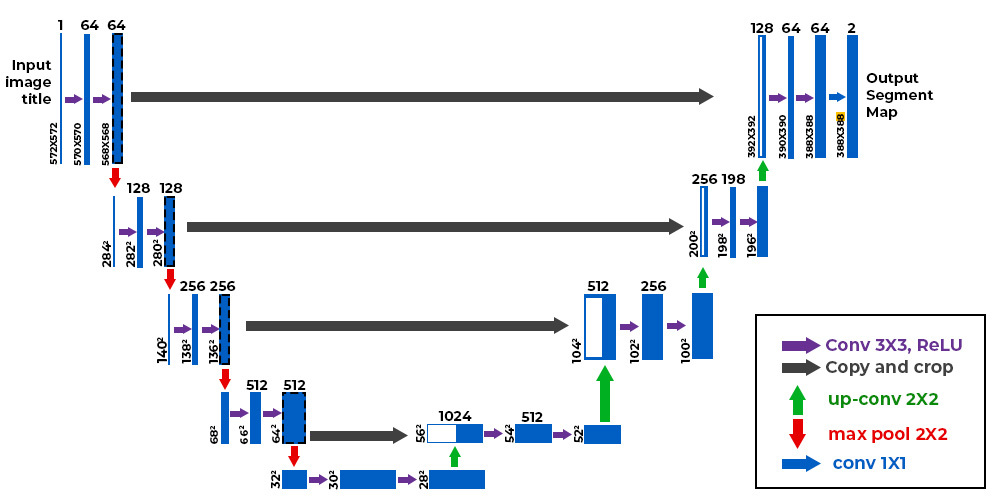

In [34]:
from IPython.display import Image
Image("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/unet image.jpg")


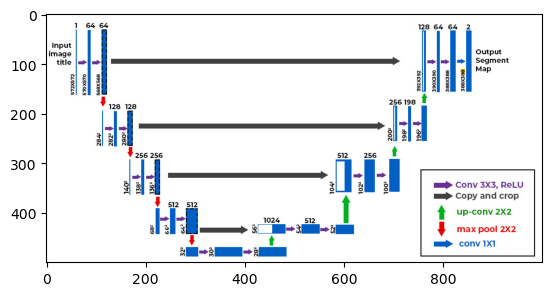

In [35]:
img = mpimg.imread("/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/unet image.jpg") #another method to display images
plt.imshow(img)
plt.show()

In [54]:
import cv2 #display image in a new window using opencv

# Load an image using OpenCV
image_path = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/unet image.jpg'
image = cv2.imread(image_path)

# Display the image in a window
cv2.imshow('Image', image)

# Wait for a key press and then close the displayed window
cv2.waitKey(0)
cv2.destroyAllWindows()


QObject::moveToThread: Current thread (0x8529c20) is not the object's thread (0x5a62270).
Cannot move to target thread (0x8529c20)

QObject::moveToThread: Current thread (0x8529c20) is not the object's thread (0x5a62270).
Cannot move to target thread (0x8529c20)

QObject::moveToThread: Current thread (0x8529c20) is not the object's thread (0x5a62270).
Cannot move to target thread (0x8529c20)

QObject::moveToThread: Current thread (0x8529c20) is not the object's thread (0x5a62270).
Cannot move to target thread (0x8529c20)

QObject::moveToThread: Current thread (0x8529c20) is not the object's thread (0x5a62270).
Cannot move to target thread (0x8529c20)

QObject::moveToThread: Current thread (0x8529c20) is not the object's thread (0x5a62270).
Cannot move to target thread (0x8529c20)

QObject::moveToThread: Current thread (0x8529c20) is not the object's thread (0x5a62270).
Cannot move to target thread (0x8529c20)

QObject::moveToThread: Current thread (0x8529c20) is not the object's thread

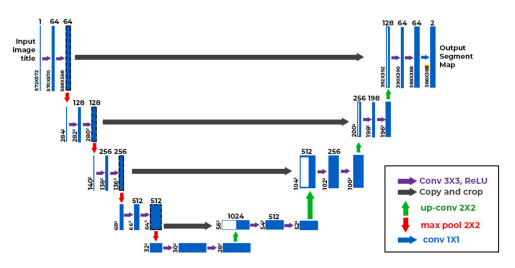

In [36]:
'''how to display image using PIL module along with matpotlib'''
from PIL import Image
import matplotlib.pyplot as plt

# Load an image using PIL
image_path = '/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/unet image.jpg'
image = Image.open(image_path)

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()


In [19]:
if torch.cuda.is_available():
    print("CUDA is available")# GPU: " + torch.cuda.get_device_name(1))
    device='cuda:1'
else:
    print("CUDA is not available.")
    device = 'cpu'

CUDA is available


In [18]:
# # To use GPU 0
# device = torch.device('cuda:0')

# # To use GPU 1
# device = torch.device('cuda:1')

In [38]:
# import torch
# import torch.nn as nn

# # Define your model
# class YourModel(nn.Module):
#     # model definition

# model = YourModel()
# model = nn.DataParallel(model, device_ids=[0, 1])
# model.to(device)

# #here dataparallel can be used to split the processes to both the gpus and it will increase the efficiency of
# #training

In [8]:
def data_loader(x,batch_size,shuffle):
    
    loader=DataLoader(x,batch_size=batch_size,shuffle=shuffle,drop_last=True)
    return loader

In [10]:
# Create DataLoader instances
batch_size = 256
shuffle = True
train_loader = data_loader(train_dataset, batch_size, shuffle)
for images, masks in train_loader:
    # images and masks are your batches of training data
    print(images.size(),masks.size())

torch.Size([256, 1, 572, 572]) torch.Size([256, 1, 572, 572])
torch.Size([256, 1, 572, 572]) torch.Size([256, 1, 572, 572])
torch.Size([256, 1, 572, 572]) torch.Size([256, 1, 572, 572])


In [11]:
#dataloader for validation and its taken as a single batch only since its testing after each epoch
batch_size = 200
shuffle = True
val_loader = data_loader(val_dataset, batch_size, shuffle)
for images, masks in val_loader:
    # images and masks are your batches of training data
    print(images.size(),masks.size())

torch.Size([200, 1, 572, 572]) torch.Size([200, 1, 572, 572])


In [12]:
def double_conv(in_c,out_c):
    '''this is the function for a sinlgle block in the encoder region'''
    conv = nn.Sequential(
    nn.Conv2d(in_c, out_c, kernel_size=3), 
    nn.ReLU(inplace=True),
    nn.Conv2d(out_c, out_c, kernel_size=3), 
    nn.ReLU(inplace=True)
    )
    
    return conv


In [13]:
def crop_img(tensor,target_tensor): #tensor is the parameter from encoder side
    '''this functions is used to have the skip connections, so for that, we need to crop images from encoder 
    side and concatenate it to the corresponding decoder block in the diagram and this function can be used to crop the
    image accordingly.'''
    
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta//2
    return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta]


In [14]:
'''the classs for the unet architecture'''
class unet(nn.Module):
    
    def __init__(self):
        
        super(unet,self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.down_conv_1 = double_conv(1,64)
        self.down_conv_2 = double_conv(64,128)
        self.down_conv_3 = double_conv(128,256)
        self.down_conv_4 = double_conv(256,512)
        self.down_conv_5 = double_conv(512,1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_1 = double_conv(1024,512)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_2 = double_conv(512,256)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_3 = double_conv(256,128)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        self.up_conv_4 = double_conv(128,64)
        
        self.out = nn.Conv2d(in_channels=64,out_channels = 1,kernel_size=2)
        
        
    '''forward pass of the encoder'''
    def forward(self,image,device = device): #(batch_size,channels,height,width)
        
        image = image.to(device)
        #encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)
        
        #decoder
        x = self.up_trans_1(x9)
        y = crop_img(x7,x)
        x = self.up_conv_1(torch.cat([x,y],1))
        
        x = self.up_trans_2(x)
        y = crop_img(x5,x)
        x = self.up_conv_2(torch.cat([x,y],1))
        
        x = self.up_trans_3(x)
        y = crop_img(x3,x)
        x = self.up_conv_3(torch.cat([x,y],1))
        
        x = self.up_trans_4(x)
        y = crop_img(x1,x)
        x = self.up_conv_4(torch.cat([x,y],1))
        
        x = self.out(x) #this should give the output segmentation mask where the number of channels will be 1 here
        
        #print(x.size())
        
        return x

In [47]:
'''this has been written for testing the network if it is working or not'''
if __name__ == '__main__':
    image = torch.rand((1,1,572,572)).to(device)
    print(image.shape)
    model = unet()
    model=model.to(device)
    a = model(image)
    print(a.size())

torch.Size([1, 1, 572, 572])
torch.Size([1, 1, 387, 387])


In [15]:
def dice_score(preds,targets,smooth=1e-6):

    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat*targets_flat).sum()
    dice = (2*intersection + smooth)/(preds_flat.sum() + targets_flat.sum())
    return dice

def dice_loss(preds,targets):
    preds_bin = (preds>0.5).float()
    score = dice_score(preds_bin,targets)
    return 1-score

In [16]:
def train(model, train_loader, val_loader, optimizer, epochs,device = device):

    
    # Put the model in training mode
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        with tqdm(train_loader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")

                # Move data to the device
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss_fn = torch.nn.CrossEntropyLoss()
                loss1 = loss_fn(outputs, labels)
                loss2 = dice_score(outputs,labels)
                loss = loss1+loss2

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Statistics
                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss/len(train_loader))

    print(f"Finished Training. Final loss: {running_loss/len(train_loader)}")


In [21]:
#Example usage
model = unet()
model = nn.DataParallel(model, device_ids=[1,0])
model  = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 10
train(model, train_loader, val_loader, optimizer, epochs,device)


Epoch 1:   0%|                                                                                 | 0/3 [00:02<?, ?batch/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument weight in method wrapper__cudnn_convolution)

In [42]:
import os
'''How os.walk() function works'''
for dirpath, dirnames, filenames in os.walk('/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net'):
    print('dirpath',dirpath)
    print('dirnames',dirnames)
    print('filenames',filenames)



In [ ]:
'''how os.dirname() works'''
# Your full path
full_path = "/media/user/data/ananthakrishnan/ananthakrishnan_architectures/u-net/test_set/file.txt"

# Get the root folder link
root_folder = os.path.dirname(full_path)

print("Root folder link:", root_folder)
